# Análise RFM em Dados de Comércio Eletrônico

## 1. Importação de Bibliotecas

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

## 2.Carregamento de Dados

In [65]:
data = pd.read_csv('data.csv', sep=',', encoding='latin1')
data = data[['CustomerID', 'Quantity', 'UnitPrice', 'InvoiceDate', 'InvoiceNo']]

## 3.Revisão de Dados

In [66]:
def review_data(df):
    isnull = df.isnull().sum()
    type_columns = df.dtypes
    pre = round((isnull/len(df))*100, 2)
    dc = pd.DataFrame({"Type":type_columns,
                       "Isnull":isnull,
                       "Missing data ٪":pre})
    print(dc.sort_values(by = "Missing data ٪", ascending = False))

review_data(data)

                Type  Isnull  Missing data ٪
CustomerID   float64  135080           24.93
Quantity       int64       0            0.00
UnitPrice    float64       0            0.00
InvoiceDate   object       0            0.00
InvoiceNo     object       0            0.00


## 4.Limpeza de Dados

In [67]:
data = data.dropna(subset= ['CustomerID', 'Quantity', 'InvoiceDate', 'UnitPrice'] )
data['InvoiceDate'] = pd.to_datetime(data_rfm['InvoiceDate'])
data['TotalPrice'] = data_rfm['Quantity'] * data_rfm['UnitPrice']

## 5.Calculo de Métricas RFM

In [68]:
reference_date = pd.to_datetime('2011-12-10')

rfm = data.groupby('CustomerID').agg({
    'InvoiceDate' : lambda x: (reference_date -x.max()).days,
    'InvoiceNo' : 'nunique',
    'TotalPrice' : 'sum'
}).rename(columns={
    'InvoiceDate' : 'Recency',
    'InvoiceNo' : 'Frequency',
    'TotalPrice' : 'Monetary'
})

## 6.Segmentação de Clientes

In [69]:
def categoria_rfm(rfm):
    if (rfm['r_score'] >= 3 and rfm['f_score'] == 1):
        return 'Recém-ativo'
    elif (rfm['r_score'] >= 3 and rfm['f_score'] >= 3):
        return 'Clientes leais'
    elif (rfm['r_score'] >= 3 and rfm['f_score'] == 2):
        return 'Clientes ativos'
    elif (rfm['r_score'] < 3 and rfm['f_score'] == 4 and rfm['m_score'] >=3):
        return 'Clientes de alto valor em risco'
    elif (rfm['r_score'] == 1 and rfm['f_score'] < 3):
        return 'Clientes inativos'
    else:
        return 'Clientes em risco'


rfm['r_score'] = pd.qcut(rfm['Recency'], 4, labels = [1, 2, 3, 4])
rfm['f_score'] = pd.qcut(rfm['Frequency'].rank(method = 'first'), 4, labels =[1, 2, 3, 4])
rfm['m_score'] = pd.qcut(rfm['Monetary'], 4, labels =[1, 2, 3, 4])
rfm['rfm_score'] = (rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str))
rfm['categoria'] = rfm.apply(categoria_rfm, axis = 1)

## Exportar excel

In [70]:
rfm.to_excel('C:/Users/gabriel.ribeiro/Desktop/rfm_ecommerce/resultado.xlsx', index=True)

## Visualizações

### Distribuição de Categorias de Clientes

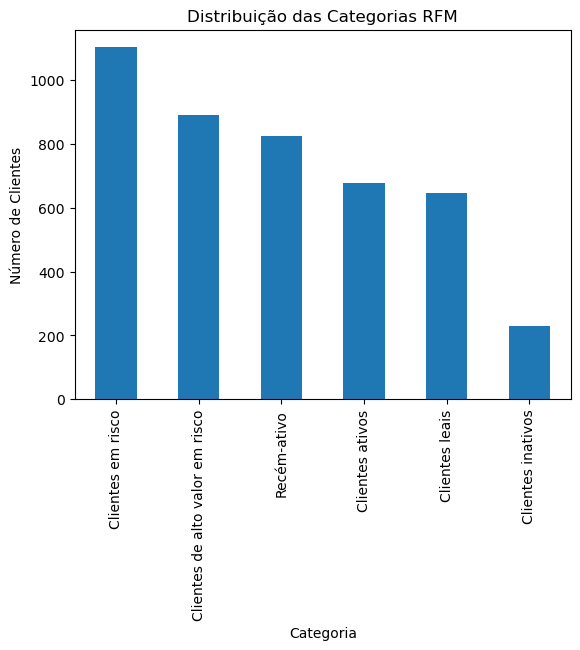

In [71]:
categoria_counts = rfm['categoria'].value_counts()
categoria_counts.plot(kind='bar')
plt.title('Distribuição das Categorias RFM')
plt.xlabel('Categoria')
plt.ylabel('Número de Clientes')
plt.show()

### Análise de Correlação

In [72]:
correlation_matrix = rfm[['Recency', 'Frequency', 'Monetary']].corr()
print(correlation_matrix)

            Recency  Frequency  Monetary
Recency    1.000000  -0.259540 -0.132109
Frequency -0.259540   1.000000  0.566122
Monetary  -0.132109   0.566122  1.000000


### Valor Médio por Categoria

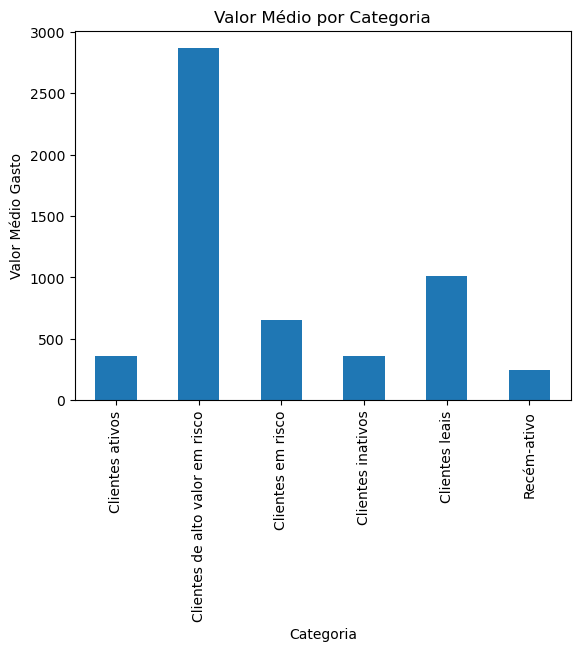

In [73]:
mean_monetary_per_category = rfm.groupby('categoria')['Monetary'].median()
mean_monetary_per_category.plot(kind='bar')
plt.title('Valor Médio por Categoria')
plt.xlabel('Categoria')
plt.ylabel('Valor Médio Gasto')
plt.show()